# Dataset

Import Data

In [94]:
!pip install lifelines

In [95]:
%pip install scikit-learn
%pip install seaborn

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.utils import concordance_index

import matplotlib.pyplot as plt
import seaborn as sns

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [96]:
df_metabric = pd.read_csv('DATA TIROID.csv')

print(f'METABRIC Dataset Shape: {df_metabric.shape}')
print(f'METABRIC Dataset Memory Usage: {df_metabric.memory_usage().sum() / 1024 ** 2:.2f} MB')

METABRIC Dataset Shape: (190, 11)
METABRIC Dataset Memory Usage: 0.02 MB


# EDA

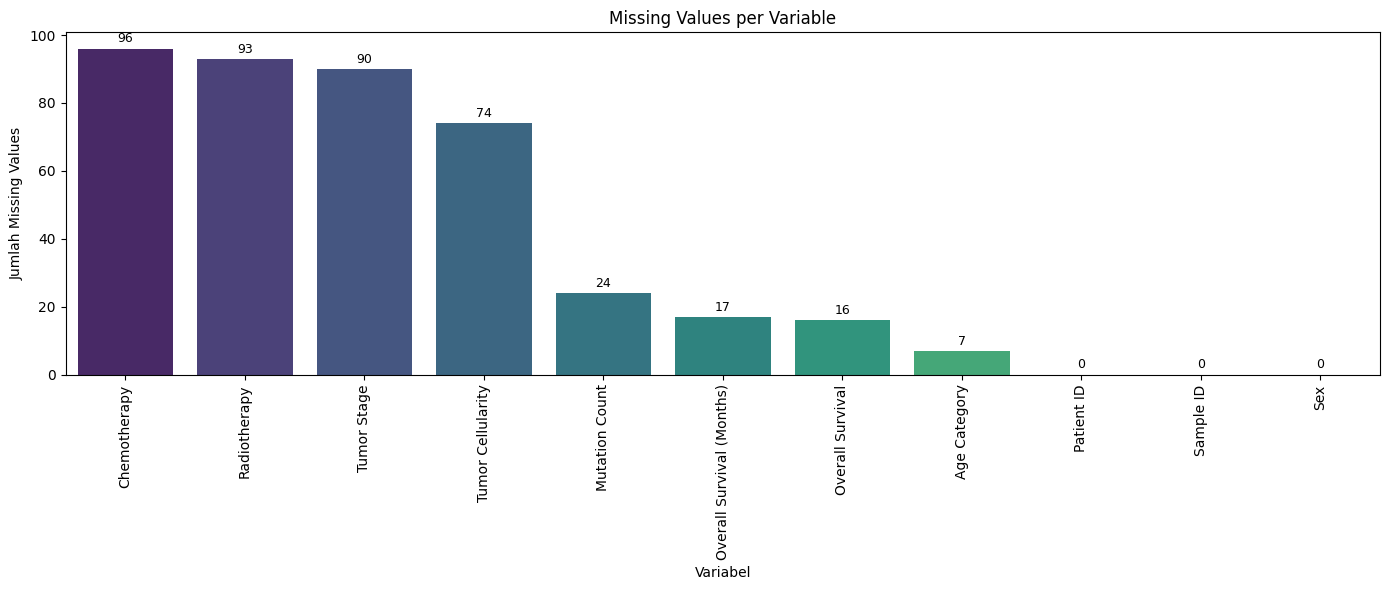

In [97]:
# Bar chart: jumlah missing value per variabel
missing = df_metabric.isna().sum().sort_values(ascending=False)

plt.figure(figsize=(14,6))
sns.barplot(x=missing.index, y=missing.values, palette='viridis')
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('Variabel')
plt.ylabel('Jumlah Missing Values')
plt.title('Missing Values per Variable')

# annotate values di atas bar
max_val = missing.values.max() if missing.values.size > 0 else 0
for i, v in enumerate(missing.values):
    plt.text(i, v + max_val * 0.01, str(int(v)), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()

# Preprocessing and Cleaning

# Handling Missing Value

In [98]:
import pandas as pd
import numpy as np
from scipy.stats import mode
import pandas.api.types as ptypes

# ----------------------
# LOGGING: Missing BEFORE
# ----------------------
print("===== MISSING VALUE SUMMARY (BEFORE PREPROCESSING) =====")
missing_before = df_metabric.isna().sum()
print(missing_before[missing_before > 0])
print("Total missing values:", missing_before.sum())
print("========================================================\n")

def get_mode_safe(s):
    if s.dropna().empty:
        return np.nan
    try:
        m = mode(s.dropna(), nan_policy='omit')
        return m.mode[0]
    except Exception:
        vc = s.dropna().value_counts()
        return vc.index[0] if not vc.empty else np.nan

def fill_group_mode(df, group_cols, target_col):
    if target_col not in df.columns:
        return df
    na_before = df[target_col].isna().sum()

    if not group_cols:
        df[target_col] = df[target_col].fillna(get_mode_safe(df[target_col]))
    else:
        if isinstance(group_cols, str):
            group_cols = [group_cols]
        ok = all(g in df.columns for g in group_cols)
        if ok:
            try:
                grp_mode = df.groupby(group_cols)[target_col].transform(lambda x: get_mode_safe(x))
                df[target_col] = df[target_col].fillna(grp_mode)
            except Exception:
                df[target_col] = df[target_col].fillna(get_mode_safe(df[target_col]))
        else:
            df[target_col] = df[target_col].fillna(get_mode_safe(df[target_col]))

    df[target_col] = df[target_col].fillna(get_mode_safe(df[target_col]))

    na_after = df[target_col].isna().sum()
    print(f"[MODE] {target_col}: filled {na_before - na_after} NA")
    return df

def fill_group_mean(df, group_cols, target_col):
    if target_col not in df.columns:
        return df

    # numeric only
    if not ptypes.is_numeric_dtype(df[target_col]):
        return fill_group_mode(df, group_cols, target_col)

    na_before = df[target_col].isna().sum()

    if not group_cols:
        df[target_col] = df[target_col].fillna(df[target_col].mean(skipna=True))
    else:
        if isinstance(group_cols, str):
            group_cols = [group_cols]
        ok = all(g in df.columns for g in group_cols)
        if ok:
            try:
                grp_mean = df.groupby(group_cols)[target_col].transform("mean")
                df[target_col] = df[target_col].fillna(grp_mean)
            except Exception:
                df[target_col] = df[target_col].fillna(df[target_col].mean(skipna=True))
        else:
            df[target_col] = df[target_col].fillna(df[target_col].mean(skipna=True))

    df[target_col] = df[target_col].fillna(df[target_col].mean(skipna=True))

    na_after = df[target_col].isna().sum()
    print(f"[MEAN] {target_col}: filled {na_before - na_after} NA")
    return df

def standardize_categorical(df, col):
    if col not in df.columns:
        return df
    df[col] = df[col].astype("string").str.strip()
    df[col] = df[col].replace({'': pd.NA, 'nan': pd.NA, 'None': pd.NA, 'NaN': pd.NA})
    df[col] = df[col].apply(lambda x: x if pd.isna(x) else str(x).title())
    return df

# ----------------------
# START PROCESSING
# ----------------------

# Standardize
for c in df_metabric.select_dtypes(include=['object','string']).columns:
    df_metabric = standardize_categorical(df_metabric, c)

# Event / Duration
if "Relapse Free Status" in df_metabric.columns:
    df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, "Relapse Free Status")

if "Relapse Free Status (Months)" in df_metabric.columns:
    grp_cols = [g for g in ["Cancer Type Detailed", "Relapse Free Status"] if g in df_metabric.columns]
    df_metabric = fill_group_mean(df_metabric, grp_cols if grp_cols else None, "Relapse Free Status (Months)")

if "Overall Survival Status" in df_metabric.columns:
    grp_cols = [g for g in ["Cancer Type Detailed", "Relapse Free Status"] if g in df_metabric.columns]
    df_metabric = fill_group_mode(df_metabric, grp_cols if grp_cols else None, "Overall Survival Status")

if "Overall Survival (Months)" in df_metabric.columns:
    grp_cols = [g for g in ["Cancer Type Detailed", "Overall Survival Status"] if g in df_metabric.columns]
    df_metabric = fill_group_mean(df_metabric, grp_cols if grp_cols else None, "Overall Survival (Months)")

# ER / PR / HER
if "ER status measured by IHC" in df_metabric.columns:
    df_metabric["ER status measured by IHC"] = df_metabric["ER status measured by IHC"].fillna(get_mode_safe(df_metabric["ER status measured by IHC"]))

if "ER Status" in df_metabric.columns:
    if "ER status measured by IHC" in df_metabric.columns:
        df_metabric = fill_group_mode(df_metabric, "ER status measured by IHC", "ER Status")
    else:
        df_metabric = fill_group_mode(df_metabric, None, "ER Status")

if "HER2 status measured by SNP6" in df_metabric.columns:
    df_metabric["HER2 status measured by SNP6"] = df_metabric["HER2 status measured by SNP6"].fillna(get_mode_safe(df_metabric["HER2 status measured by SNP6"]))

if "HER2 Status" in df_metabric.columns:
    if "HER2 status measured by SNP6" in df_metabric.columns:
        df_metabric = fill_group_mode(df_metabric, "HER2 status measured by SNP6", "HER2 Status")
    else:
        df_metabric = fill_group_mode(df_metabric, None, "HER2 Status")

if "PR Status" in df_metabric.columns:
    df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, "PR Status")

# Therapies
for col in ["Chemotherapy","Hormone Therapy","Radio Therapy"]:
    if col in df_metabric.columns:
        df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, col)

# Numeric
if "Age at Diagnosis" in df_metabric.columns:
    df_metabric = fill_group_mean(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, "Age at Diagnosis")

if "Cohort" in df_metabric.columns:
    if ptypes.is_numeric_dtype(df_metabric["Cohort"]):
        if "Cancer Type Detailed" in df_metabric.columns:
            before = df_metabric["Cohort"].isna().sum()
            try:
                df_metabric["Cohort"] = df_metabric["Cohort"].fillna(df_metabric.groupby("Cancer Type Detailed")["Cohort"].transform("median"))
            except:
                df_metabric["Cohort"] = df_metabric["Cohort"].fillna(df_metabric["Cohort"].median())
            after = df_metabric["Cohort"].isna().sum()
            print(f"[MEDIAN] Cohort: filled {before - after} NA")
        else:
            df_metabric["Cohort"] = df_metabric["Cohort"].fillna(df_metabric["Cohort"].median())
    else:
        df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, "Cohort")

# Categorical
for col in ["Cellularity","Tumor Other Histologic Subtype","Primary Tumor Laterality",
            "Mutation Count","Lymph nodes examined positive","Inferred Menopausal State",
            "Pam50 + Claudin-low subtype","Type of Breast Surgery","3-Gene classifier subtype"]:

    if col in df_metabric.columns:
        df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, col)

# Tumor Stage & Tumor Size
if "Tumor Stage" in df_metabric.columns:
    if ptypes.is_numeric_dtype(df_metabric["Tumor Stage"]):
        before = df_metabric["Tumor Stage"].isna().sum()
        df_metabric["Tumor Stage"] = df_metabric["Tumor Stage"].fillna(df_metabric["Tumor Stage"].median())
        after = df_metabric["Tumor Stage"].isna().sum()
        print(f"[MEDIAN] Tumor Stage: filled {before - after} NA")
    else:
        df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, "Tumor Stage")

if "Tumor Size" in df_metabric.columns:
    if ptypes.is_numeric_dtype(df_metabric["Tumor Size"]):
        before = df_metabric["Tumor Size"].isna().sum()
        df_metabric["Tumor Size"] = df_metabric["Tumor Size"].fillna(df_metabric["Tumor Size"].median())
        after = df_metabric["Tumor Size"].isna().sum()
        print(f"[MEDIAN] Tumor Size: filled {before - after} NA")
    else:
        df_metabric = fill_group_mode(df_metabric, "Cancer Type Detailed" if "Cancer Type Detailed" in df_metabric.columns else None, "Tumor Size")

# Nottingham Index
if "Nottingham prognostic index" in df_metabric.columns:
    if ptypes.is_numeric_dtype(df_metabric["Nottingham prognostic index"]):
        before = df_metabric["Nottingham prognostic index"].isna().sum()
        df_metabric["Nottingham prognostic index"] = df_metabric["Nottingham prognostic index"].fillna(df_metabric["Nottingham prognostic index"].median())
        after = df_metabric["Nottingham prognostic index"].isna().sum()
        print(f"[MEDIAN] Nottingham prognostic index: filled {before - after} NA")
    else:
        df_metabric = fill_group_mode(df_metabric, None, "Nottingham prognostic index")

# Drop column
if "Patient's Vital Status" in df_metabric.columns:
    df_metabric.drop(columns=["Patient's Vital Status"], inplace=True)
    print("[DROP] Removed column: Patient's Vital Status")

# Final fallback
for c in df_metabric.columns:
    if df_metabric[c].isna().any():
        before = df_metabric[c].isna().sum()
        if ptypes.is_numeric_dtype(df_metabric[c]):
            df_metabric[c] = df_metabric[c].fillna(df_metabric[c].median())
        else:
            df_metabric[c] = df_metabric[c].fillna(get_mode_safe(df_metabric[c]))
        after = df_metabric[c].isna().sum()
        print(f"[FINAL FILL] {c}: filled {before - after} NA")

# ----------------------
# LOGGING: Missing AFTER
# ----------------------
print("\n===== MISSING VALUE SUMMARY (AFTER PREPROCESSING) =====")
missing_after = df_metabric.isna().sum()
print(missing_after[missing_after > 0])
print("Total missing values:", missing_after.sum())
print("=======================================================\n")

print("Total NA fixed:", missing_before.sum() - missing_after.sum())
print("\n>>> Preprocessing complete on df_metabric <<<")


===== MISSING VALUE SUMMARY (BEFORE PREPROCESSING) =====
Age Category                  7
Chemotherapy                 96
Mutation Count               24
Overall Survival             16
Overall Survival (Months)    17
Radiotherapy                 93
Tumor Cellularity            74
Tumor Stage                  90
dtype: int64
Total missing values: 417

[MEAN] Overall Survival (Months): filled 17 NA
[MODE] Chemotherapy: filled 96 NA
[MODE] Mutation Count: filled 24 NA
[MODE] Tumor Stage: filled 90 NA
[FINAL FILL] Age Category: filled 7 NA
[FINAL FILL] Overall Survival: filled 16 NA
[FINAL FILL] Radiotherapy: filled 93 NA
[FINAL FILL] Tumor Cellularity: filled 74 NA

===== MISSING VALUE SUMMARY (AFTER PREPROCESSING) =====
Series([], dtype: int64)
Total missing values: 0

Total NA fixed: 417

>>> Preprocessing complete on df_metabric <<<


In [99]:
df_metabric.head()

,Patient ID,Sample ID,Age Category,Chemotherapy,Mutation Count,Overall Survival,Overall Survival (Months),Radiotherapy,Sex,Tumor Cellularity,Tumor Stage
0,Anpt0001,Anpt0001P,<70,No,283.0,1:Deceased,1.774127e+08,No,Male,0.360,T4A
1,Anpt0002,Anpt0002P,<70,Yes,159.0,1:Deceased,2.796632e+09,Yes,Female,0.635,T4B
2,Anpt0003,Anpt0003P,>=70,Yes,61.0,1:Deceased,3.318275e+09,Yes,Female,0.530,T4B
3,Anpt0004,Anpt0004P,<70,Yes,216.0,1:Deceased,1.117043e+09,Yes,Female,0.360,T4B
4,Anpt0005,Anpt0005P,>=70,No,277.0,1:Deceased,2.299795e-01,No,Male,0.635,T4B


Encoding & Transformasi

In [100]:
# Encoding / transformation (Label Encoding + binary mapping) with logging.
from sklearn.preprocessing import LabelEncoder
import numpy as np

# list of categorical columns to label-encode (adjust if perlu)
object_cols = ['Type of Breast Surgery', 'Cancer Type', 'Cancer Type Detailed', 'Cellularity',
               'Chemotherapy', 'Pam50 + Claudin-low subtype', 'ER status measured by IHC',
               'ER Status', 'HER2 status measured by SNP6', 'HER2 Status', 'Tumor Other Histologic Subtype',
               'Hormone Therapy', 'Inferred Menopausal State', 'Integrative Cluster', 'Primary Tumor Laterality',
               'Oncotree Code', 'PR Status', 'Radio Therapy', 'Sex', '3-Gene classifier subtype', 'Age Category', 'Radiotherapy', 'Surgery', 'Distant Metastasis', 'Nodal Metastasis', 'Leukocytosis', 'Tumor Stage']

encoders = {}   # store LabelEncoders and mappings

print("===== START ENCODING =====\n")
for col in object_cols:
    if col not in df_metabric.columns:
        print(f"[SKIP] Column not in dataframe: {col}")
        continue

    # Get column series (assume missing handled; but be defensive)
    s = df_metabric[col].astype(str).fillna("NA_MISSING")
    unique_vals = pd.Index(s.unique())
    n_unique = unique_vals.size

    # if binary-like with values 'Yes'/'No' or 'Positive'/'Negative', you may prefer a manual mapping,
    # but here we use LabelEncoder for consistency
    le = LabelEncoder()
    le.fit(s)
    transformed = le.transform(s)

    # choose minimal integer dtype
    dtype = np.uint8 if n_unique <= 255 else np.int32
    df_metabric[col] = transformed.astype(dtype)

    # store encoder and mapping for reproducibility
    mapping = {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}
    encoders[col] = {"encoder": le, "mapping": mapping}

    print(f"[ENCODE] {col}: {n_unique} categories -> dtype {dtype.__name__}")
    # show up to 8 mapping examples
    sample_map = dict(list(mapping.items())[:8])
    print("   sample mapping:", sample_map)
print("\n===== Categorical encoding complete =====\n")

# ---- Binary mappings for status columns (preferred explicit mapping for survival) ----
# For each, if mapping keys exactly match, apply; otherwise fall back to LabelEncoder with a warning.

def safe_binary_map(df, col, mapping, col_name_for_log=None):
    col_name_for_log = col_name_for_log or col
    if col not in df.columns:
        print(f"[SKIP] Binary map: column not found: {col}")
        return
    unique_vals = pd.Series(df[col].unique())
    # check if all non-null values are in mapping keys
    present = set([str(x) for x in unique_vals if pd.notna(x)])
    keys = set(mapping.keys())
    if present.issubset(keys):
        df[col] = df[col].map(mapping).astype(np.uint8)
        print(f"[BINARY MAP] {col_name_for_log}: applied explicit mapping -> {mapping}")
    else:
        print(f"[WARN] {col_name_for_log}: values {sorted(list(present - keys))} not in mapping keys; falling back to LabelEncoder")
        le = LabelEncoder()
        s = df[col].astype(str).fillna("NA_MISSING")
        le.fit(s)
        df[col] = le.transform(s).astype(np.uint8 if le.classes_.size <= 255 else np.int32)
        encoders[col_name_for_log] = {"encoder": le, "mapping": {str(k): int(v) for k, v in zip(le.classes_, le.transform(le.classes_))}}
        print(f"        fallback mapping sample: {dict(list(encoders[col_name_for_log]['mapping'].items())[:8])}")

# mapping for Overall Survival Status
safe_binary_map(df_metabric, 'Overall Survival Status', {'1:Living': 0, '1:Deceased': 1}, 'Overall Survival Status')

# mapping for Relapse Free Status
safe_binary_map(df_metabric, 'Relapse Free Status', {'Not Recurred': 0, 'Recurred': 1}, 'Relapse Free Status')

# ---- Summary logging ----
print("\n===== ENCODING SUMMARY =====")

===== START ENCODING =====

[SKIP] Column not in dataframe: Type of Breast Surgery
[SKIP] Column not in dataframe: Cancer Type
[SKIP] Column not in dataframe: Cancer Type Detailed
[SKIP] Column not in dataframe: Cellularity
[ENCODE] Chemotherapy: 2 categories -> dtype uint8
   sample mapping: {'No': 0, 'Yes': 1}
[SKIP] Column not in dataframe: Pam50 + Claudin-low subtype
[SKIP] Column not in dataframe: ER status measured by IHC
[SKIP] Column not in dataframe: ER Status
[SKIP] Column not in dataframe: HER2 status measured by SNP6
[SKIP] Column not in dataframe: HER2 Status
[SKIP] Column not in dataframe: Tumor Other Histologic Subtype
[SKIP] Column not in dataframe: Hormone Therapy
[SKIP] Column not in dataframe: Inferred Menopausal State
[SKIP] Column not in dataframe: Integrative Cluster
[SKIP] Column not in dataframe: Primary Tumor Laterality
[SKIP] Column not in dataframe: Oncotree Code
[SKIP] Column not in dataframe: PR Status
[SKIP] Column not in dataframe: Radio Therapy
[ENCODE] 

In [101]:
# Tampilkan seluruh baris dan kolom dataframe di Jupyter (tanpa memodifikasi global settings permanen)
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.width', 2000):
    display(df_metabric)

,Patient ID,Sample ID,Age Category,Chemotherapy,Mutation Count,Overall Survival,Overall Survival (Months),Radiotherapy,Sex,Tumor Cellularity,Tumor Stage
0,Anpt0001,Anpt0001P,0,0,283.0,1:Deceased,1.774127e+08,0,1,0.360,0
1,Anpt0002,Anpt0002P,0,1,159.0,1:Deceased,2.796632e+09,1,0,0.635,1
2,Anpt0003,Anpt0003P,1,1,61.0,1:Deceased,3.318275e+09,1,0,0.530,1
3,Anpt0004,Anpt0004P,0,1,216.0,1:Deceased,1.117043e+09,1,0,0.360,1
4,Anpt0005,Anpt0005P,1,0,277.0,1:Deceased,2.299795e-01,0,1,0.635,1
5,Anpt0006,Anpt0006P,0,1,366.0,1:Deceased,1.347023e+09,1,1,0.500,1
6,Anpt0007,Anpt0007P,0,1,392.0,1:Deceased,1.895688e+09,0,0,0.635,1
7,Anpt0008,Anpt0008P,0,1,184.0,1:Deceased,1.195893e+09,1,0,1.000,1
8,Anpt0009,Anpt0009P,1,1,277.0,1:Deceased,6.899384e-01,1,0,0.550,1
9,Anpt0010,Anpt0010P,0,1,541.0,1:Deceased,8.936345e+09,1,0,0.540,1


Korelasi

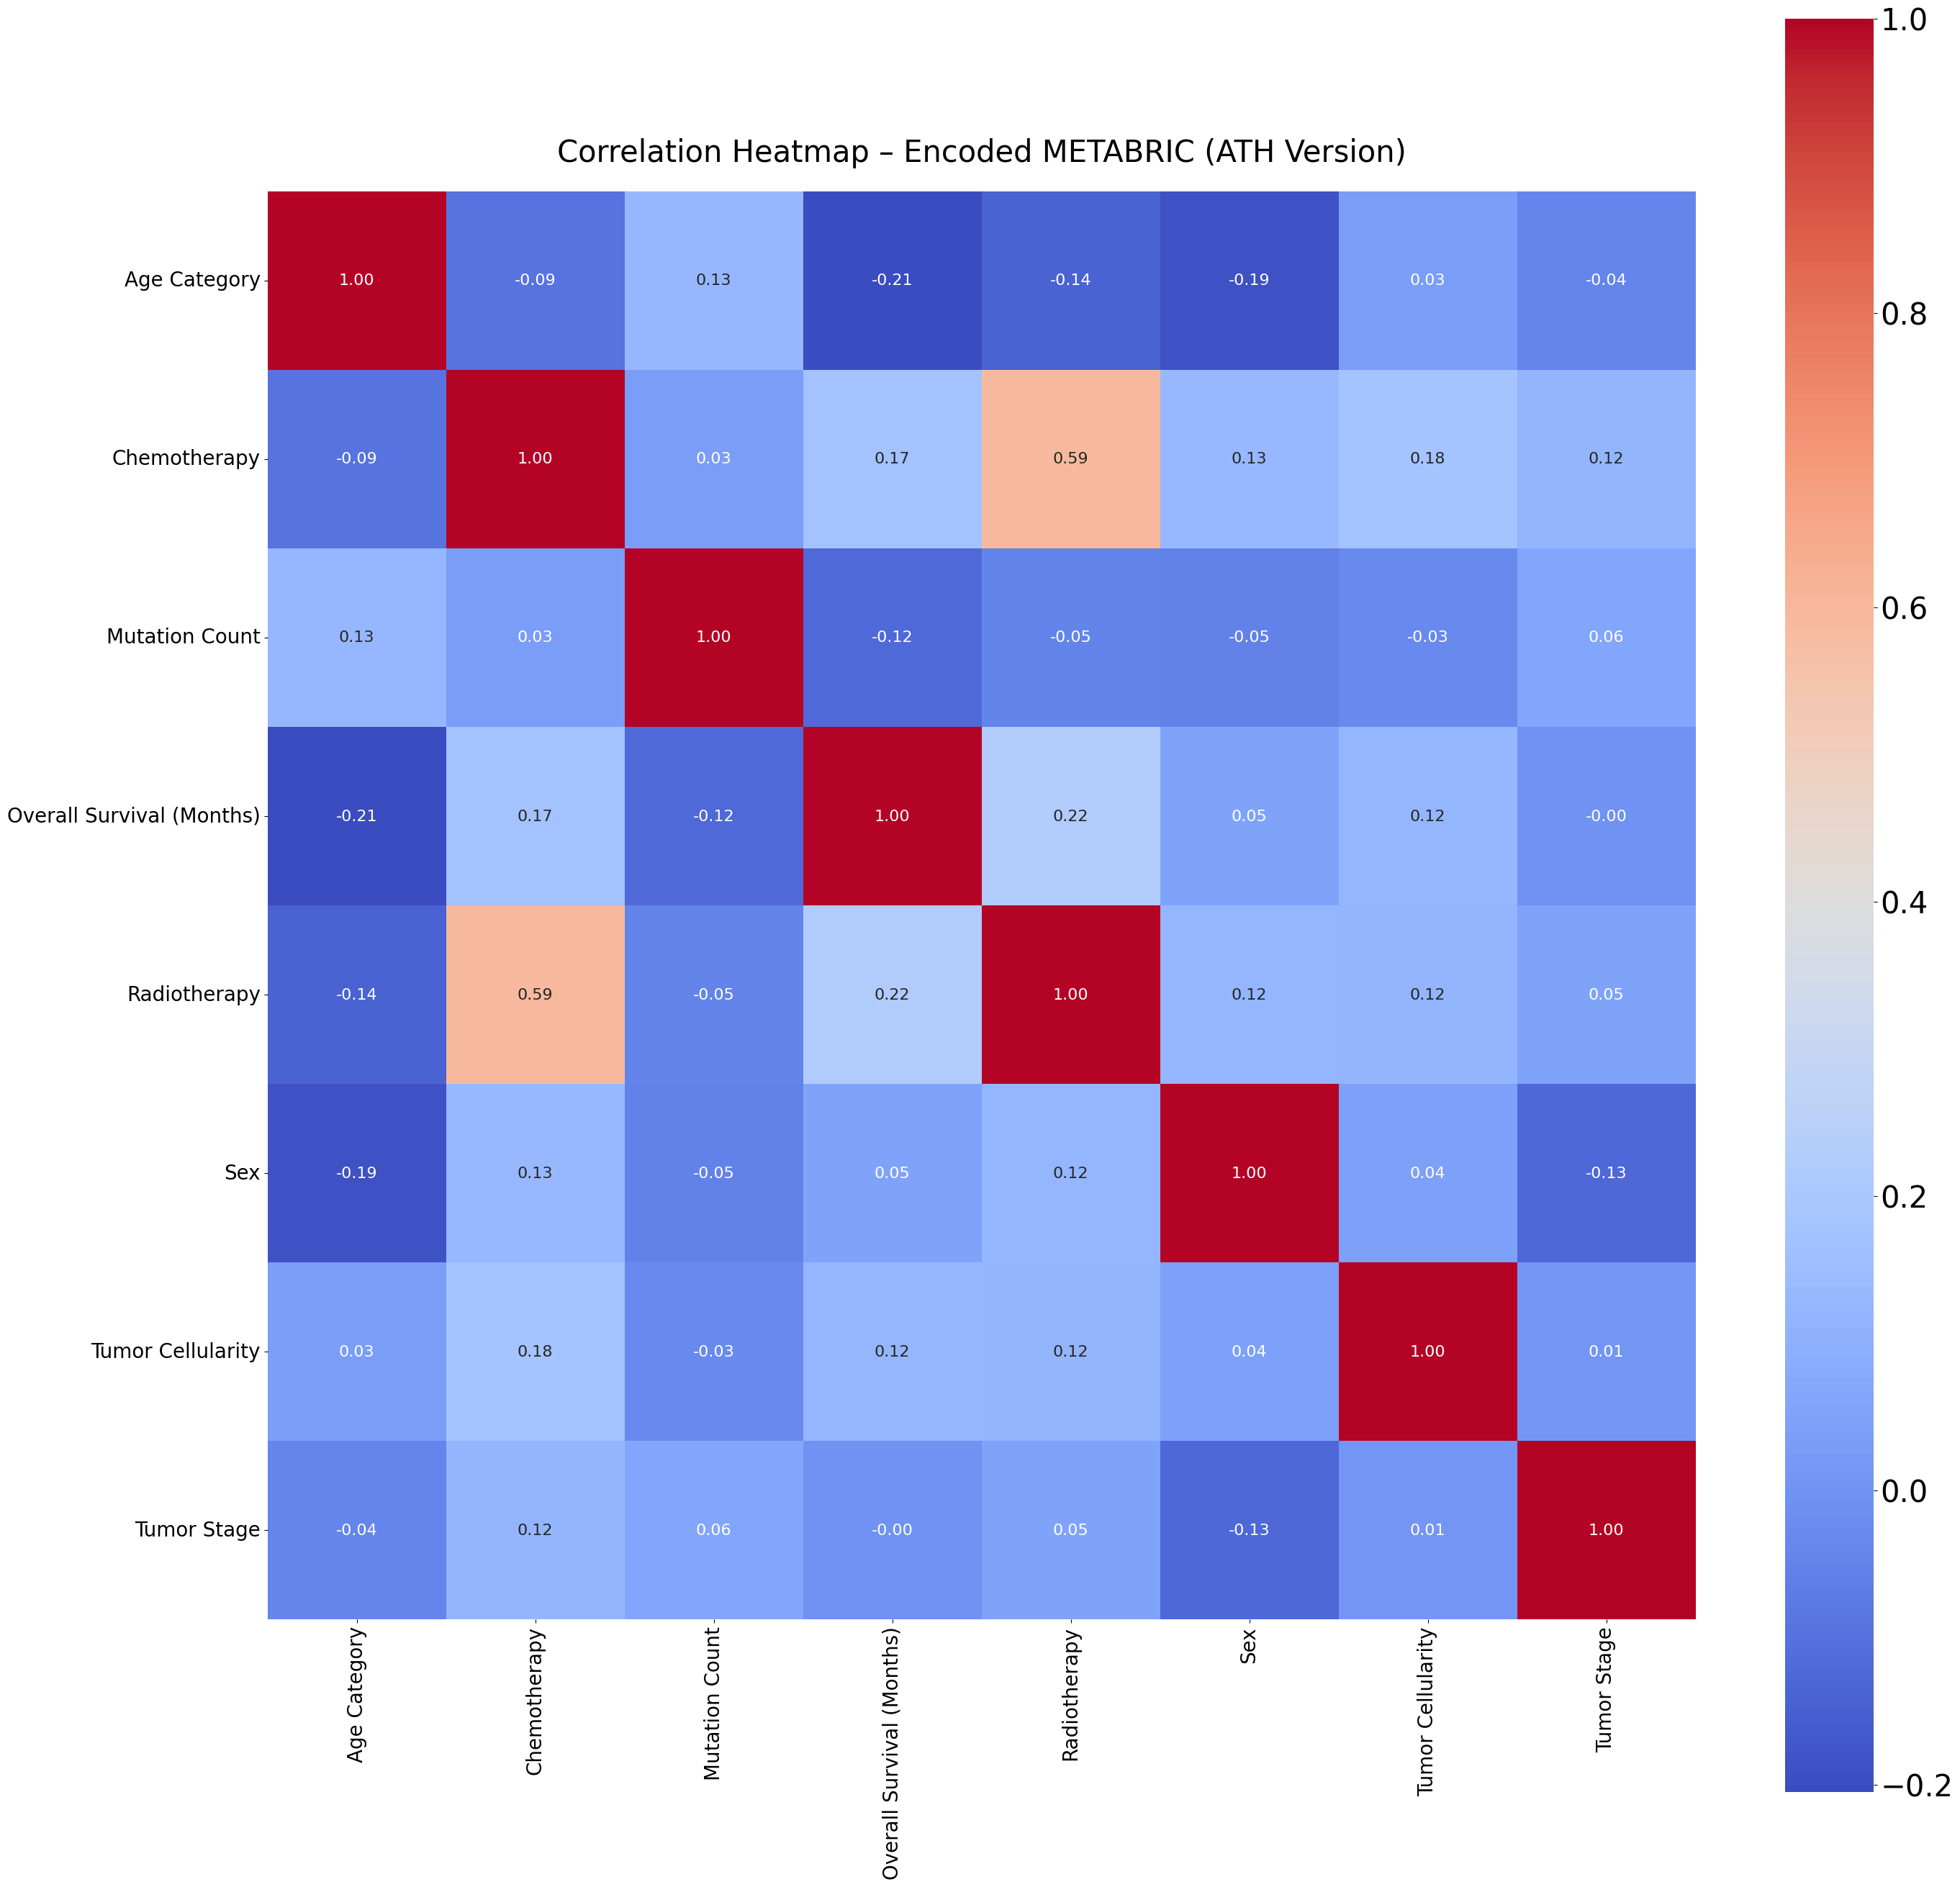

In [102]:
import matplotlib.pyplot as plt
import seaborn as sns

# pastikan hanya numeric columns yg dipakai untuk korelasi
corr_matrix = df_metabric.select_dtypes(include=['number']).corr()

plt.figure(figsize=(32, 32), dpi=100)

ax = sns.heatmap(
    corr_matrix,
    annot=True,
    square=True,
    cmap='coolwarm',
    annot_kws={'size': 16},
    fmt='.2f'
)

# Perbesar label colorbar
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=30)

# Ukuran label sumbu
plt.tick_params(axis='x', labelsize=20, rotation=90)
plt.tick_params(axis='y', labelsize=20, rotation=0)

plt.title('Correlation Heatmap – Encoded METABRIC (ATH Version)', size=30, pad=30)

plt.show()


Radioterapi dan kemoterapi merupakan bagian dari terapi multimodal yang umumnya diberikan secara bersamaan. Radioterapi bertujuan mengontrol penyakit lokal, sedangkan kemoterapi diberikan untuk pengendalian sistemik. Oleh karena itu, dalam praktik klinis, pasien yang menerima radioterapi hampir selalu menerima kemoterapi, sehingga korelasi antarkeduanya pada dataset sangat tinggi.

## Penanganan Variabel Korelasi Tinggi

Combined Treatment Variable

In [103]:
# Pastikan kolom bertipe integer (0/1)
df_metabric['Chemotherapy'] = df_metabric['Chemotherapy'].astype(int)
df_metabric['Radiotherapy'] = df_metabric['Radiotherapy'].astype(int)

# Buat variabel gabungan dalam bentuk kategori string
def classify_treatment(row):
    if row['Radiotherapy'] == 0 and row['Chemotherapy'] == 0:
        return 'No Treatment'
    elif row['Radiotherapy'] == 1 and row['Chemotherapy'] == 0:
        return 'Radiotherapy Only'
    elif row['Radiotherapy'] == 0 and row['Chemotherapy'] == 1:
        return 'Chemotherapy Only'
    elif row['Radiotherapy'] == 1 and row['Chemotherapy'] == 1:
        return 'Combined Therapy'

df_metabric['Treatment Group'] = df_metabric.apply(classify_treatment, axis=1)


In [104]:
df_metabric['Treatment Group'].value_counts()


Treatment Group
Combined Therapy     165
No Treatment          11
Radiotherapy Only     11
Chemotherapy Only      3
Name: count, dtype: int64

In [105]:
# 1. Buat variabel gabungan Treatment Group
df_metabric['Treatment Group'] = df_metabric.apply(classify_treatment, axis=1)

df_metabric = pd.get_dummies(df_metabric, columns=['Treatment Group'], drop_first=True)



In [106]:
# Pisahkan angka sebelum ":" dan convert ke int
df_metabric['Overall Survival'] = df_metabric['Overall Survival'].str.split(':').str[0].astype(int)

# Cek hasilnya
df_metabric['Overall Survival'].value_counts()

Overall Survival
1    154
0     36
Name: count, dtype: int64

Encode

In [107]:
for col in df_metabric.filter(like='Treatment Group_'):
    df_metabric[col] = df_metabric[col].astype(int)


In [109]:
for col in df_metabric.filter(like='Treatment Group_'):
    df_metabric[col] = df_metabric[col].astype(int)


In [110]:
df_metabric.head()

,Patient ID,Sample ID,Age Category,Chemotherapy,Mutation Count,Overall Survival,Overall Survival (Months),Radiotherapy,Sex,Tumor Cellularity,Tumor Stage,Treatment Group_Combined Therapy,Treatment Group_No Treatment,Treatment Group_Radiotherapy Only
0,Anpt0001,Anpt0001P,0,0,283.0,1,1.774127e+08,0,1,0.360,0,0,1,0
1,Anpt0002,Anpt0002P,0,1,159.0,1,2.796632e+09,1,0,0.635,1,1,0,0
2,Anpt0003,Anpt0003P,1,1,61.0,1,3.318275e+09,1,0,0.530,1,1,0,0
3,Anpt0004,Anpt0004P,0,1,216.0,1,1.117043e+09,1,0,0.360,1,1,0,0
4,Anpt0005,Anpt0005P,1,0,277.0,1,2.299795e-01,0,1,0.635,1,0,1,0


# Kaplan Meier Test

Kolom Durasi & Event 

In [111]:
# Tentukan kolom waktu dan status event
duration_col = 'Overall Survival (Months)'
event_col = 'Overall Survival'

# Pastikan keduanya tidak mengandung nilai kosong
print(df_metabric[[duration_col, event_col]].isna().sum())


Overall Survival (Months)    0
Overall Survival             0
dtype: int64


## Kaplan Meier Treatment Group

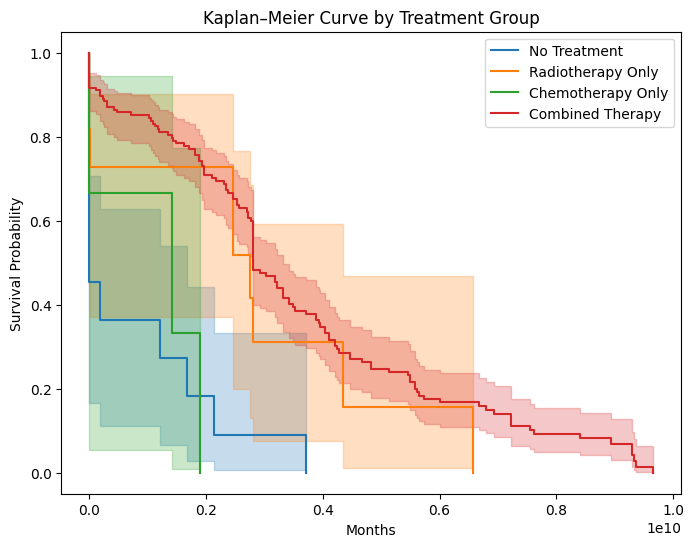

In [115]:
# Reconstruct 'Treatment Group' if it was replaced by dummies earlier
if 'Treatment Group' not in df_metabric.columns:
    mapping = {
        'Treatment Group_Combined Therapy': 'Combined Therapy',
        'Treatment Group_No Treatment': 'No Treatment',
        'Treatment Group_Radiotherapy Only': 'Radiotherapy Only'
    }
    df_metabric['Treatment Group'] = 'Unknown'
    for col, label in mapping.items():
        if col in df_metabric.columns:
            df_metabric.loc[df_metabric[col] == 1, 'Treatment Group'] = label

    # infer remaining rows from Chemotherapy/Radiotherapy flags if available
    if {'Chemotherapy', 'Radiotherapy'}.issubset(df_metabric.columns):
        unk = df_metabric['Treatment Group'] == 'Unknown'
        df_metabric.loc[unk & (df_metabric['Chemotherapy'] == 1) & (df_metabric['Radiotherapy'] == 0), 'Treatment Group'] = 'Chemotherapy Only'
        df_metabric.loc[unk & (df_metabric['Chemotherapy'] == 0) & (df_metabric['Radiotherapy'] == 1), 'Treatment Group'] = 'Radiotherapy Only'
        df_metabric.loc[unk & (df_metabric['Chemotherapy'] == 0) & (df_metabric['Radiotherapy'] == 0), 'Treatment Group'] = 'No Treatment'
        df_metabric.loc[unk & (df_metabric['Chemotherapy'] == 1) & (df_metabric['Radiotherapy'] == 1), 'Treatment Group'] = 'Combined Therapy'

km = KaplanMeierFitter()
plt.figure(figsize=(8,6))

# define preferred order, skip groups with no data
groups = ['No Treatment', 'Radiotherapy Only', 'Chemotherapy Only', 'Combined Therapy']
for group in groups:
    mask = (df_metabric['Treatment Group'] == group) & df_metabric[duration_col].notna() & df_metabric[event_col].notna()
    if mask.sum() == 0:
        continue
    km.fit(df_metabric.loc[mask, duration_col], df_metabric.loc[mask, event_col], label=group)
    km.plot(ci_show=True)

plt.title("Kaplan–Meier Curve by Treatment Group")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


### KM Radioterapi

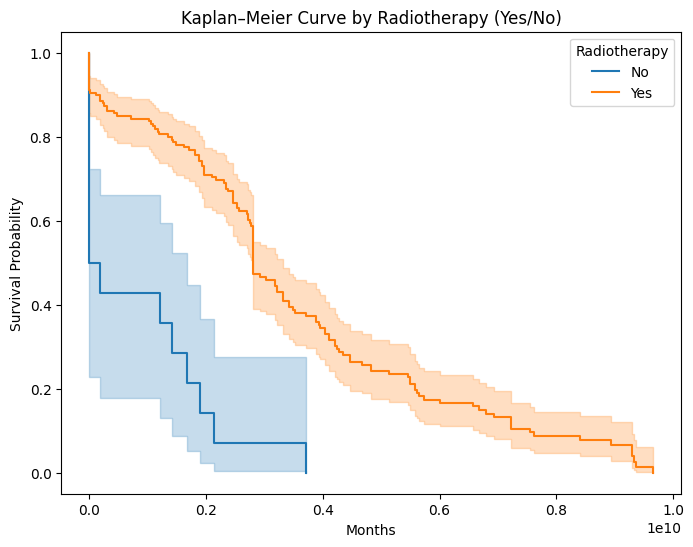

In [120]:
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt

km = KaplanMeierFitter()

plt.figure(figsize=(8,6))

for group in df_metabric['Radiotherapy'].unique():
    mask = df_metabric['Radiotherapy'] == group
    label = "Yes" if group == 1 else "No"
    
    km.fit(
        df_metabric.loc[mask, 'Overall Survival (Months)'],
        df_metabric.loc[mask, 'Overall Survival'],
        label=label
    )
    km.plot(ci_show=True)

plt.title("Kaplan–Meier Curve by Radiotherapy (Yes/No)")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.legend(title="Radiotherapy")
plt.show()


### KM Chemoterapi

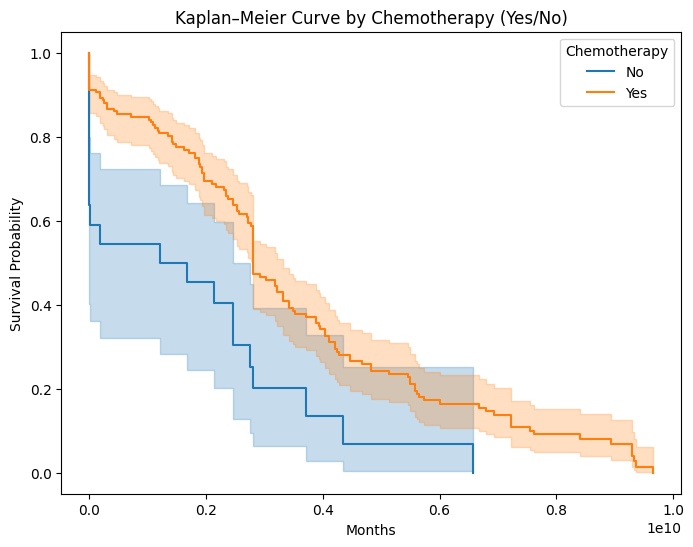

In [121]:
plt.figure(figsize=(8,6))

for group in df_metabric['Chemotherapy'].unique():
    mask = df_metabric['Chemotherapy'] == group
    label = "Yes" if group == 1 else "No"
    
    km.fit(
        df_metabric.loc[mask, 'Overall Survival (Months)'],
        df_metabric.loc[mask, 'Overall Survival'],
        label=label
    )
    km.plot(ci_show=True)

plt.title("Kaplan–Meier Curve by Chemotherapy (Yes/No)")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.legend(title="Chemotherapy")
plt.show()


## KM Age Category

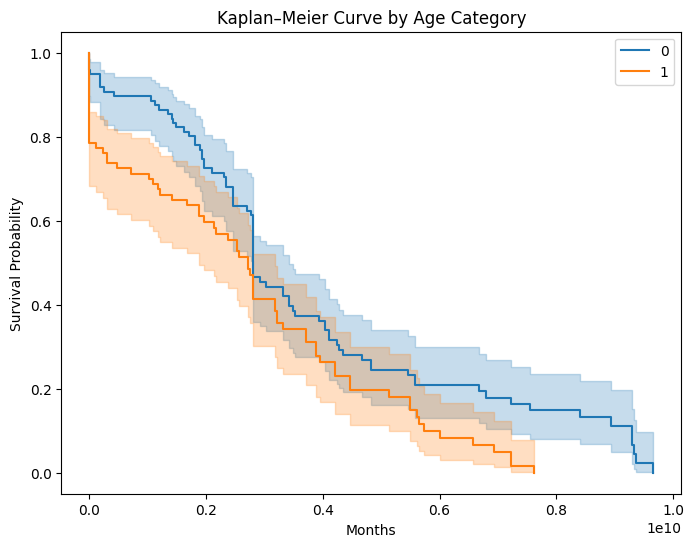

In [116]:
plt.figure(figsize=(8,6))

for age in df_metabric['Age Category'].unique():
    mask = df_metabric['Age Category'] == age
    km.fit(df_metabric.loc[mask, duration_col],
           df_metabric.loc[mask, event_col],
           label=str(age))
    km.plot(ci_show=True)

plt.title("Kaplan–Meier Curve by Age Category")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


## KM Sex

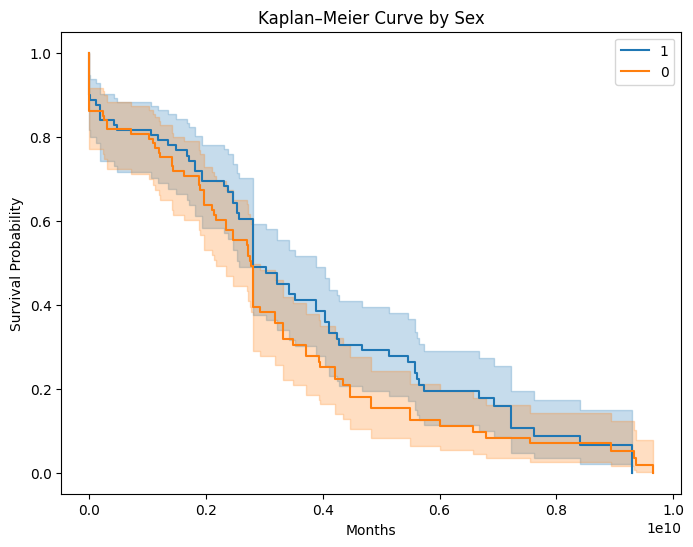

In [117]:
plt.figure(figsize=(8,6))

for s in df_metabric['Sex'].unique():
    mask = df_metabric['Sex'] == s
    km.fit(df_metabric.loc[mask, duration_col],
           df_metabric.loc[mask, event_col],
           label=s)
    km.plot(ci_show=True)

plt.title("Kaplan–Meier Curve by Sex")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


## KM Tumor Stage

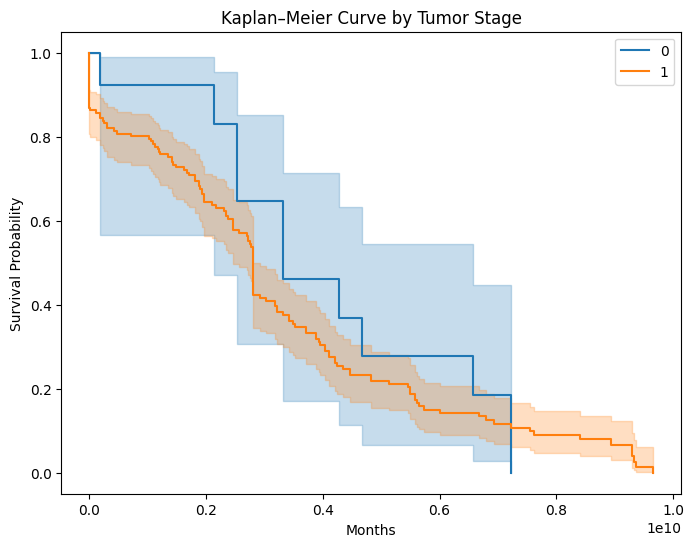

In [118]:
plt.figure(figsize=(8,6))

for stage in df_metabric['Tumor Stage'].unique():
    mask = df_metabric['Tumor Stage'] == stage
    km.fit(df_metabric.loc[mask, duration_col],
           df_metabric.loc[mask, event_col],
           label=stage)
    km.plot(ci_show=True)

plt.title("Kaplan–Meier Curve by Tumor Stage")
plt.xlabel("Months")
plt.ylabel("Survival Probability")
plt.show()


## Uji Log Rank

In [122]:
from lifelines.statistics import logrank_test, multivariate_logrank_test
import itertools

# Tentukan kolom durasi & event
duration_col = 'Overall Survival (Months)'
event_col = 'Overall Survival'

# Daftar variabel untuk uji log-rank
logrank_vars = ['Radiotherapy', 'Chemotherapy', 'Sex', 'Age Category', 'Tumor Stage']

print("\n===== HASIL UJI LOG-RANK =====\n")

for var in logrank_vars:
    print(f"Variable: {var}")

    # Ambil kategori unik
    groups = df_metabric[var].dropna().unique()

    # -------------------------------------------------------
    # Jika kategorinya hanya 2 → simple log-rank test
    # -------------------------------------------------------
    if len(groups) == 2:
        g1, g2 = groups[0], groups[1]

        mask1 = df_metabric[var] == g1
        mask2 = df_metabric[var] == g2

        lr = logrank_test(
            df_metabric.loc[mask1, duration_col],
            df_metabric.loc[mask2, duration_col],
            event_observed_A=df_metabric.loc[mask1, event_col],
            event_observed_B=df_metabric.loc[mask2, event_col]
        )
        print(f"  {g1} vs {g2} → p-value = {lr.p_value:.5f}\n")

    # -------------------------------------------------------
    # Jika kategorinya lebih dari 2 → multivariate log-rank
    # -------------------------------------------------------
    else:
        try:
            lr = multivariate_logrank_test(
                df_metabric[duration_col],
                df_metabric[var],
                df_metabric[event_col]
            )
            print(f"  Overall log-rank p-value = {lr.p_value:.5f}\n")

        except:
            # fallback ke pairwise comparison
            print("  (Multivariate failed, performing pairwise tests)")
            pairs = itertools.combinations(groups, 2)
            for g1, g2 in pairs:
                mask1 = df_metabric[var] == g1
                mask2 = df_metabric[var] == g2

                lr = logrank_test(
                    df_metabric.loc[mask1, duration_col],
                    df_metabric.loc[mask2, duration_col],
                    event_observed_A=df_metabric.loc[mask1, event_col],
                    event_observed_B=df_metabric.loc[mask2, event_col]
                )
                print(f"  {g1} vs {g2} → p-value = {lr.p_value:.5f}")
            print()



===== HASIL UJI LOG-RANK =====

Variable: Radiotherapy
  0 vs 1 → p-value = 0.00000

Variable: Chemotherapy
  0 vs 1 → p-value = 0.00044

Variable: Sex
  1 vs 0 → p-value = 0.20884

Variable: Age Category
  0 vs 1 → p-value = 0.00596

Variable: Tumor Stage
  0 vs 1 → p-value = 0.43323



p < 0.05 → signifikan.

# Regresi Cox

Persiapan Data

In [123]:
from lifelines import CoxPHFitter
import pandas as pd

# Pilih variabel yang masuk Cox (wajib)
cox_vars = ['Radiotherapy', 'Chemotherapy', 'Age Category']

# Buat dataframe khusus Cox
df_cox = df_metabric[[ 'Overall Survival (Months)', 
                       'Overall Survival'] + cox_vars].copy()

# One-hot encode untuk Age Category
df_cox = pd.get_dummies(df_cox, columns=['Age Category'], drop_first=True)

df_cox.head()


,Overall Survival (Months),Overall Survival,Radiotherapy,Chemotherapy,Age Category_1
0,1.774127e+08,1,0,0,False
1,2.796632e+09,1,1,1,False
2,3.318275e+09,1,1,1,True
3,1.117043e+09,1,1,1,False
4,2.299795e-01,1,0,0,True


## Goodness-of-Fit (Hanya variabel signifikan)

In [134]:
from lifelines.statistics import proportional_hazard_test

# Hanya variabel signifikan log-rank:
cox_vars_final = ['Radiotherapy', 'Chemotherapy', 'Age Category']

df_ph = df_metabric[['Overall Survival (Months)', 
                     'Overall Survival'] + cox_vars_final].copy()

# Dummy encode Age Category (untuk Cox)
df_ph = pd.get_dummies(df_ph, columns=['Age Category'], drop_first=True)

# Fit Cox model
from lifelines import CoxPHFitter
cph = CoxPHFitter()
cph.fit(df_ph, duration_col='Overall Survival (Months)', event_col='Overall Survival')

# Uji Goodness of Fit
results = proportional_hazard_test(cph, df_ph, time_transform="rank")

# Tabel GOF
gof_table = results.summary
print(gof_table)


                test_statistic         p  -log2(p)
Age Category_1        0.256626  0.612448  0.707341
Chemotherapy          0.198804  0.655688  0.608919
Radiotherapy          0.244294  0.621122  0.687052


Lolos uji asumsi semua (p-value > 0,05)

## Cox Univariat

In [125]:
cph = CoxPHFitter()

for var in df_cox.columns:
    if var in ['Overall Survival (Months)', 'Overall Survival']:
        continue
    
    print("\n==============================")
    print("UNIVARIATE COX FOR:", var)
    
    cph.fit(df_cox[['Overall Survival (Months)', 
                    'Overall Survival', var]],
            duration_col='Overall Survival (Months)',
            event_col='Overall Survival')
    
    print(cph.summary)



UNIVARIATE COX FOR: Radiotherapy
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z             p   -log2(p)
covariate                                                                                                                                                       
Radiotherapy -1.633993   0.195149  0.292832       -2.207933       -1.060052             0.109928             0.346438     0.0 -5.579961  2.405731e-08  25.308949

UNIVARIATE COX FOR: Chemotherapy
                  coef  exp(coef)  se(coef)  coef lower 95%  coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%  cmp to         z         p   -log2(p)
covariate                                                                                                                                                   
Chemotherapy -0.822562   0.439305  0.243292       -1.299405       -0.345718             0.272694             0.707712     0.0 -3.380962

## Cox Multivariat

In [129]:
# Install missing package (use notebook magic)
%pip install jinja2

cph_multi = CoxPHFitter()

cph_multi.fit(df_cox,
              duration_col='Overall Survival (Months)',
              event_col='Overall Survival')

cph_multi.print_summary()



   ---------------------------------------- 2/2 [jinja2]

Note: you may need to restart the kernel to use updated packages.


<lifelines.CoxPHFitter: fitted with 190 total observations, 36 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival'
      baseline estimation = breslow
   number of observations = 190
number of events observed = 154
   partial log-likelihood = -638.26
         time fit was run = 2025-12-12 20:44:34 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Radiotherapy   -1.33      0.26      0.38           -2.08           -0.59                0.12                0.56
Chemotherapy   -0.22      0.80      0.32           -0.85            0.40                0.43                1.50
Age Category_1  0.32      1.38      0.17           -0.02            0.66                0.98                1.94

                cmp to     z      p  -log2(p)
covariate                                    
Radiotherapy      0.00 -3.49 <0.005     11.04
Chemotherapy      0.00 -0.70   0.49      1.04
Age Category_1    0.00  1.86   0.06      4.00
---
Concordance = 0.61
Partial AIC = 1282.52
log-likelihood ratio test = 25.73 on 3 df
-log2(p) of ll-ratio test = 16.49

In [132]:
summary = cph_multi.summary

# Pilih kolom penting
table_cox = summary[['coef', 'se(coef)', 'exp(coef)', 'exp(coef) lower 95%', 'exp(coef) upper 95%', 'p']]

# Ubah nama kolom agar sama seperti jurnal
table_cox.columns = ['β', 'SE(β)', 'HR', 'HR Lower 95%', 'HR Upper 95%', 'p-value']

print(table_cox)


                       β     SE(β)        HR  HR Lower 95%  HR Upper 95%   p-value
covariate                                                                         
Radiotherapy   -1.332771  0.381400  0.263745      0.124893      0.556972  0.000475
Chemotherapy   -0.223016  0.319787  0.800102      0.427506      1.497438  0.485560
Age Category_1  0.322178  0.172925  1.380130      0.983390      1.936932  0.062448


Radiotherapy → signifikan → harus dipertahankan.

Chemotherapy → tidak signifikan → layak dieliminasi.

Age Category → borderline (p=0.06); di jurnal biasanya dibandingkan melalui seleksi backward.

## Seleksi Backward (Cox PH Final Only Radiotherapy + Age Category)

In [135]:
df_best = df_cox[['Overall Survival (Months)',
                   'Overall Survival',
                   'Radiotherapy',
                   'Age Category_1']]

from lifelines import CoxPHFitter
cph_best = CoxPHFitter()

cph_best.fit(df_best,
             duration_col='Overall Survival (Months)',
             event_col='Overall Survival')

cph_best.print_summary()


<lifelines.CoxPHFitter: fitted with 190 total observations, 36 right-censored observations>
             duration col = 'Overall Survival (Months)'
                event col = 'Overall Survival'
      baseline estimation = breslow
   number of observations = 190
number of events observed = 154
   partial log-likelihood = -638.49
         time fit was run = 2025-12-12 20:54:27 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
Radiotherapy   -1.50      0.22      0.30           -2.08           -0.91                0.12                0.40
Age Category_1  0.33      1.40      0.17           -0.00            0.67                1.00                1.96

                cmp to     z      p  -log2(p)
covariate                                    
Radiotherapy      0.00 -4.99 <0.005     20.62
Age Category_1    0.00  1.94   0.05      4.27
---
Concordance = 0.60
Partial AIC = 1280.99
log-likelihood ratio test = 25.26 on 2 df
-log2(p) of ll-ratio test = 18.22

Berdasarkan hasil seleksi model menggunakan metode backward elimination, diperoleh bahwa model terbaik terdiri dari dua variabel, yaitu radiotherapy dan age category. Variabel chemotherapy dieliminasi karena tidak signifikan pada model awal.

Model Cox Proportional Hazards terbaik dapat dituliskan sebagai:

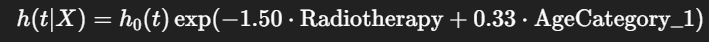

## Metode Bootstrap

In [137]:
import numpy as np
import pandas as pd
from lifelines import CoxPHFitter

# Data model terbaik
df_best = df_cox[['Overall Survival (Months)',
                   'Overall Survival',
                   'Radiotherapy',
                   'Age Category_1']].copy()

# Ensure numeric dtype to avoid bool/collinearity issues in small samples
df_best['Age Category_1'] = df_best['Age Category_1'].astype(int)
df_best['Radiotherapy'] = df_best['Radiotherapy'].astype(int)

# Model awal untuk mendapatkan parameter (use small penalizer to improve numerical stability)
cph_best = CoxPHFitter(penalizer=0.1)
cph_best.fit(df_best, 
             duration_col='Overall Survival (Months)',
             event_col='Overall Survival')

# Bootstrap ----------------------------------------
n_boot = 1000  # jumlah bootstrap (1000 ideal untuk laporan)
boot_coefs = []
n_success = 0
n_attempts = 0
max_attempts = n_boot * 10  # safety cap

while n_success < n_boot and n_attempts < max_attempts:
    n_attempts += 1
    # sampling with replacement
    sample_df = df_best.sample(frac=1, replace=True)
    
    # skip samples where any covariate is constant (would make matrix singular)
    if (sample_df[['Radiotherapy', 'Age Category_1']].nunique() < 2).any():
        continue

    try:
        # fit ulang Cox pada sample bootstrap with penalizer
        cph_boot = CoxPHFitter(penalizer=0.1)
        cph_boot.fit(sample_df,
                     duration_col='Overall Survival (Months)',
                     event_col='Overall Survival')
        boot_coefs.append(cph_boot.params_.values)
        n_success += 1
    except Exception:
        # skip failed bootstrap sample (e.g., convergence/matrix issues)
        continue

if n_success < n_boot:
    print(f"[WARN] Only {n_success} successful bootstrap samples collected after {n_attempts} attempts")

boot_coefs = np.array(boot_coefs)

# Hitung Bootstrap CI 95% (use available successful samples)
lower = np.percentile(boot_coefs, 2.5, axis=0)
upper = np.percentile(boot_coefs, 97.5, axis=0)

# Membuat tabel hasil
bootstrap_ci_table = pd.DataFrame({
    "Variable": cph_best.params_.index,
    "Coef Estimate": cph_best.params_.values,
    "Lower 95% (Bootstrap)": lower,
    "Upper 95% (Bootstrap)": upper,
    "HR Estimate": np.exp(cph_best.params_.values),
    "HR Lower 95% Boot": np.exp(lower),
    "HR Upper 95% Boot": np.exp(upper)
})

print(bootstrap_ci_table)


         Variable  Coef Estimate  Lower 95% (Bootstrap)  Upper 95% (Bootstrap)  HR Estimate  HR Lower 95% Boot  HR Upper 95% Boot
0    Radiotherapy      -1.346175              -2.188467              -0.805254     0.260234           0.112088           0.446974
1  Age Category_1       0.310777               0.024939               0.586407     1.364485           1.025252           1.797517


Berdasarkan parameter yang diperoleh dari proses bootstrap sebanyak 1000 replikasi, model Cox Proportional Hazards terbaik dapat dituliskan sebagai:
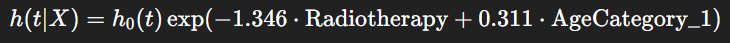